Notebook d'exploration et validation des données Elasticsearch
Débats de l'Assemblée Nationale - Projet Fenêtre d'Overton


# 📊 Exploration des données Elasticsearch

Ce notebook permet de valider visuellement que vos données sont correctement indexées
dans Elasticsearch et correspondent à vos attentes pour le projet d'analyse du

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from elasticsearch import Elasticsearch
from datetime import datetime
import json
from collections import Counter
from wordcloud import WordCloud

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


In [2]:
es = Elasticsearch("http://localhost:9200")

# Vérifier la connexion
if es.ping():
    print("✅ Connexion à Elasticsearch réussie")
    
    # Informations sur le cluster
    info = es.info()
    print(f"\n📌 Version Elasticsearch: {info['version']['number']}")
    print(f"📌 Nom du cluster: {info['cluster_name']}")
else:
    print("❌ Impossible de se connecter à Elasticsearch")

print(info)

✅ Connexion à Elasticsearch réussie

📌 Version Elasticsearch: 8.16.0
📌 Nom du cluster: docker-cluster
{'name': 'd32be7c0cd01', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'oY25cj4NSEex3enPw8cK9w', 'version': {'number': '8.16.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '12ff76a92922609df4aba61a368e7adf65589749', 'build_date': '2024-11-08T10:05:56.292914697Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


2️⃣ Informations sur l'index


In [3]:
index_name = "debats_assemblee_nationale" #Change le nom de l'index si nécessaire

# Vérifier si l'index existe
if es.indices.exists(index=index_name):
    print(f"✅ L'index '{index_name}' existe\n")
    
    # Statistiques de l'index
    stats = es.indices.stats(index=index_name)
    count = es.count(index=index_name)
    
    print(f"📊 Statistiques de l'index:")
    print(f"   • Nombre total de documents: {count['count']:,}")
    print(f"   • Taille de l'index: {stats['indices'][index_name]['total']['store']['size_in_bytes'] / (1024*1024):.2f} MB")
    
    # Mapping de l'index
    mapping = es.indices.get_mapping(index=index_name)
    properties = mapping[index_name]['mappings']['properties']
    print(f"   • Nombre de champs: {len(properties)}")
    
else:
    print(f"❌ L'index '{index_name}' n'existe pas")
    print("Exécutez d'abord le script d'extraction pour créer l'index")


✅ L'index 'debats_assemblee_nationale' existe

📊 Statistiques de l'index:
   • Nombre total de documents: 469,327
   • Taille de l'index: 253.08 MB
   • Nombre de champs: 18


3️⃣ Aperçu du mapping (structure des données)


In [5]:
print("🗺️  Structure des données (Mapping):\n")
for field, details in sorted(properties.items()):
    field_type = details.get('type', 'object')
    print(f"   • {field:30s} → {field_type}")


🗺️  Structure des données (Mapping):

   • annee                          → long
   • date_parution                  → date
   • date_seance                    → date
   • extraction_timestamp           → date
   • legislature                    → long
   • mois                           → long
   • numero_premiere_page           → long
   • orateur_fonction               → text
   • orateur_nom                    → text
   • para_id                        → text
   • publication_numero             → long
   • section_id                     → text
   • section_titre                  → text
   • session_nom                    → text
   • session_parlementaire          → text
   • sous_section_titre             → text
   • texte                          → text
   • vote_present                   → boolean


4️⃣ Échantillon de documents

In [6]:
sample_query = {
    "size": 3,
    "sort": [{"date_seance": {"order": "desc"}}]
}

response = es.search(index=index_name, body=sample_query)

print(f"📄 Échantillon de {len(response['hits']['hits'])} documents:\n")
print("=" * 80)

for i, hit in enumerate(response['hits']['hits'], 1):
    doc = hit['_source']
    print(f"\n🔹 Document {i}:")
    print(f"   Date séance: {doc.get('date_seance', 'N/A')}")
    print(f"   Législature: {doc.get('legislature', 'N/A')}")
    print(f"   Orateur: {doc.get('orateur_nom', 'N/A')}")
    print(f"   Fonction: {doc.get('orateur_fonction', 'N/A')}")
    print(f"   Section: {doc.get('section_titre', 'N/A')[:80]}...")
    print(f"   Texte (extrait): {doc.get('texte', 'N/A')[:150]}...")
    print(f"   Vote présent: {doc.get('vote_present', False)}")
    if doc.get('vote_present'):
        print(f"   Votes pour: {doc.get('votes_pour', 'N/A')}, contre: {doc.get('votes_contre', 'N/A')}")



C:\Users\simon\AppData\Local\Temp\ipykernel_7192\3396805782.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=sample_query)


📄 Échantillon de 3 documents:


🔹 Document 1:
   Date séance: 2020-12-17
   Législature: 15
   Orateur: M. le président.
   Fonction: Président
   Section: projet de loi de finances pour 2021...
   Texte (extrait): L’ordre du jour appelle la discussion, en lecture définitive, du projet de loi de finances pour 2021 (n os  3704, 3705)....
   Vote présent: False

🔹 Document 2:
   Date séance: 2020-12-17
   Législature: 15
   Orateur: M. le président.
   Fonction: Président
   Section: projet de loi de finances pour 2021...
   Texte (extrait): La séance est suspendue....
   Vote présent: False

🔹 Document 3:
   Date séance: 2020-12-17
   Législature: 15
   Orateur: M. le président.
   Fonction: Président
   Section: projet de loi de finances pour 2021...
   Texte (extrait): La séance est reprise....
   Vote présent: False


5️⃣ Conversion en DataFrame pour analyse

In [8]:
def get_all_documents(index_name, batch_size=1000):
    """
    Récupère tous les documents d'un index avec pagination
    """
    documents = []
    
    # Première requête
    response = es.search(
        index=index_name,
        scroll='2m',
        size=batch_size,
        body={"query": {"match_all": {}}}
    )
    
    scroll_id = response['_scroll_id']
    hits = response['hits']['hits']
    documents.extend([hit['_source'] for hit in hits])
    
    print(f"Récupération des documents: {len(documents)}", end="")
    
    # Pagination
    while len(hits) > 0:
        response = es.scroll(scroll_id=scroll_id, scroll='2m')
        scroll_id = response['_scroll_id']
        hits = response['hits']['hits']
        documents.extend([hit['_source'] for hit in hits])
        print(f"...{len(documents)}", end="")
    
    print(f" ✅ Terminé!")
    
    # Nettoyer le scroll
    es.clear_scroll(scroll_id=scroll_id)
    
    return documents

print("📥 Récupération de tous les documents...")
all_docs = get_all_documents(index_name)
df = pd.DataFrame(all_docs)

print(f"\n✅ DataFrame créé avec {len(df):,} lignes et {len(df.columns)} colonnes")

# %% Afficher les premières lignes
print("\n📋 Aperçu du DataFrame:")
df.head()


📥 Récupération de tous les documents...
Récupération des documents: 1000...2000

C:\Users\simon\AppData\Local\Temp\ipykernel_7192\1680772219.py:8: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(


...3000...4000...5000...6000...7000...8000...9000...10000...11000...12000...13000...14000...15000...16000...17000...18000...19000...20000...21000...22000...23000...24000...25000...26000...27000...28000...29000...30000...31000...32000...33000...34000...35000...36000...37000...38000...39000...40000...41000...42000...43000...44000...45000...46000...47000...48000...49000...50000...51000...52000...53000...54000...55000...56000...57000...58000...59000...60000...61000...62000...63000...64000...65000...66000...67000...68000...69000...70000...71000...72000...73000...74000...75000...76000...77000...78000...79000...80000...81000...82000...83000...84000...85000...86000...87000...88000...89000...90000...91000...92000...93000...94000...95000...96000...97000...98000...99000...100000...101000...102000...103000...104000...105000...106000...107000...108000...109000...110000...111000...112000...113000...114000...115000...116000...117000...118000...119000...120000...121000...122000...123000...124000...125

(469327, 18)

In [17]:
liste_section = pd.DataFrame(df['section_titre'].value_counts())
liste_section

,count
section_titre,
Questions au Gouvernement,36428
Projet de loi de finances pour 2019,24108
Projet de loi de finances pour 2020,24082
Projet de loi de finances pour 2021,23354
Système universel de retraite,21238
...,...
Hommage à M. Samuel Paty,1
Remplacement de députés,1
Démission d’une députée,1


In [20]:
# Filtrer pour ne garder que les lignes contenant "immigration"
liste_section_immigration = liste_section[liste_section.index.str.contains('immigration', case=False, na=False)]
print(f"🔍 Sections contenant 'immigration': {len(liste_section_immigration)} résultats\n")
liste_section_immigration

🔍 Sections contenant 'immigration': 2 résultats



,count
section_titre,
"Immigration maîtrisée, droit d’asile effectif et intégration réussie",12374
"Immigration maîtrisée, droit d’asile effectif et intégration réussie (suite)",207


In [23]:
response = es.search(
    index=index_name,
    query={"term": {"section_id": "w1aab2ab1ab1i01181"}},
    size=1
)
response

ObjectApiResponse({'took': 25, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}})

In [27]:
df_vote = df["vote_present"]
df_vote.value_counts()


vote_present
False    469327
Name: count, dtype: int64

6️⃣ Statistiques descriptives

In [28]:
df.info()

# %% Statistiques par colonne
print("\n📈 Statistiques descriptives:")
print(f"\n{'='*60}")
print(f"Période couverte:")
print(f"   • Première séance: {df['date_seance'].min()}")
print(f"   • Dernière séance: {df['date_seance'].max()}")
print(f"\n{'='*60}")
print(f"Législatures:")
print(df['legislature'].value_counts().sort_index())
print(f"\n{'='*60}")
print(f"Sessions:")
print(df['session_nom'].value_counts())
print(f"\n{'='*60}")
print(f"Fonctions des orateurs:")
print(df['orateur_fonction'].value_counts())
print(f"\n{'='*60}")
print(f"Interventions avec vote:")
print(df['vote_present'].value_counts())
print(f"\n{'='*60}")
print(f"Statistiques sur la longueur des textes:")
df['texte_length'] = df['texte'].str.len()
print(df['texte_length'].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469327 entries, 0 to 469326
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   publication_numero     469327 non-null  int64 
 1   date_parution          469327 non-null  object
 2   date_seance            469327 non-null  object
 3   annee                  469327 non-null  int64 
 4   mois                   469327 non-null  int64 
 5   session_nom            469327 non-null  object
 6   session_parlementaire  469327 non-null  object
 7   legislature            469327 non-null  int64 
 8   numero_premiere_page   469327 non-null  int64 
 9   section_id             469327 non-null  object
 10  section_titre          469327 non-null  object
 11  sous_section_titre     459159 non-null  object
 12  para_id                469327 non-null  object
 13  orateur_nom            469324 non-null  object
 14  orateur_fonction       469324 non-null  object
 15  

7️⃣ Visualisations


C:\Users\simon\AppData\Local\Temp\ipykernel_7192\2996448431.py:46: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\simon\AppData\Local\Temp\ipykernel_7192\2996448431.py:46: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\simon\AppData\Local\Temp\ipykernel_7192\2996448431.py:46: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\simon\AppData\Local\Temp\ipykernel_7192\2996448431.py:46: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\simon\miniconda3\envs\datadebat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\simon\miniconda3\envs\datadebat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) mis

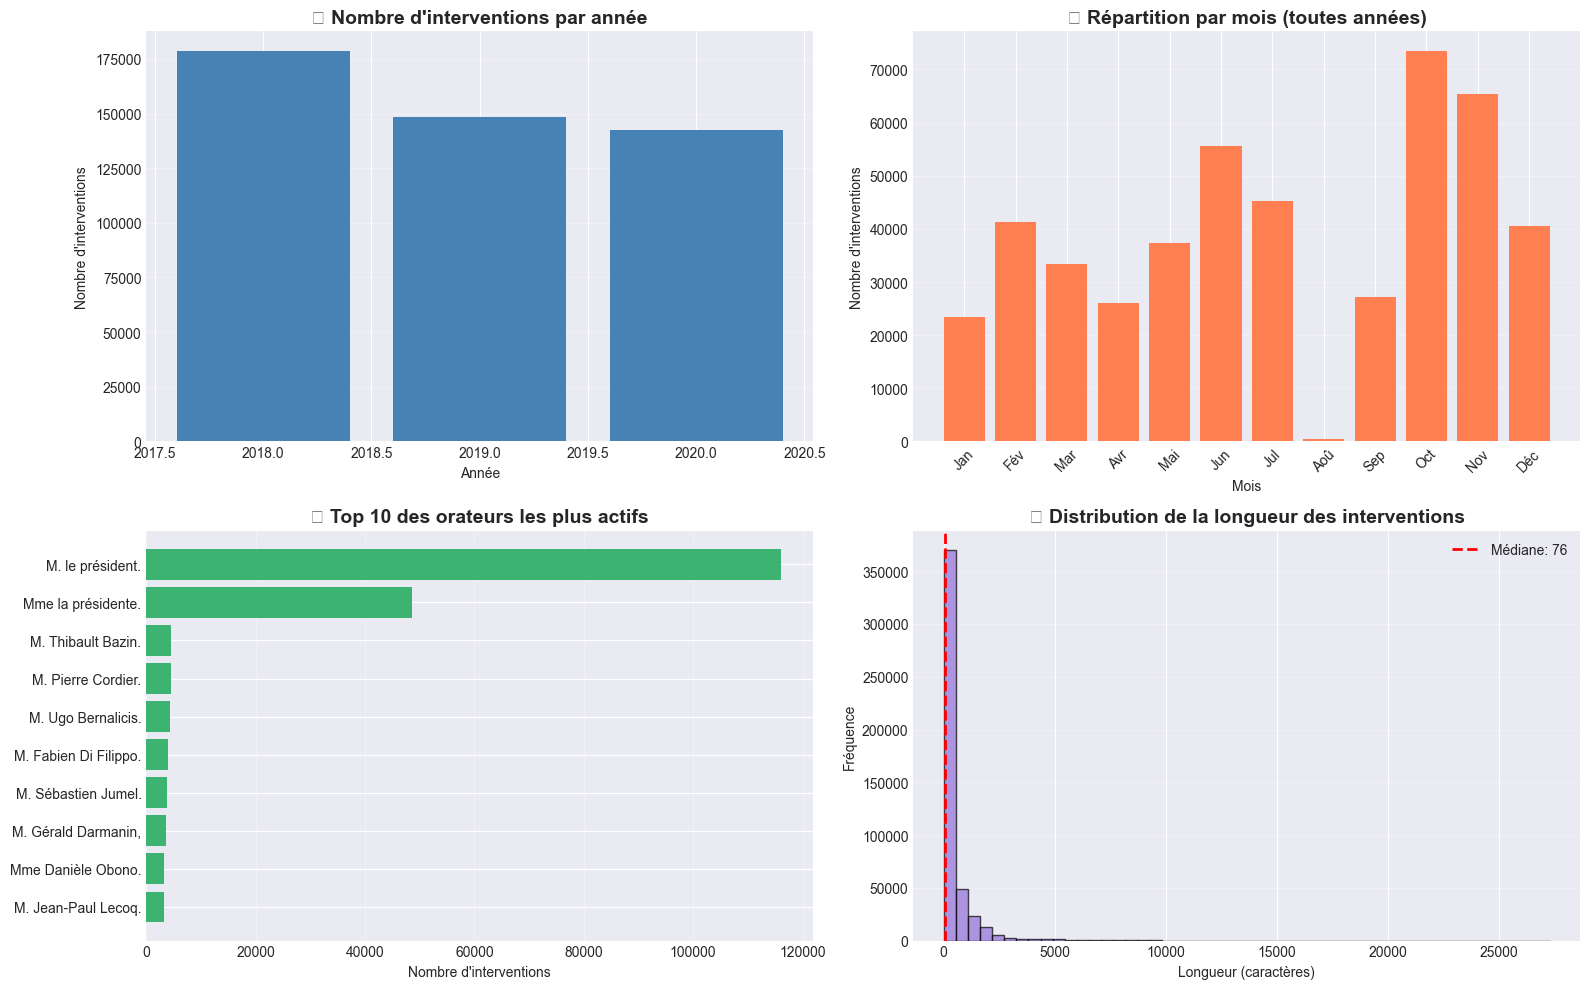

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Convertir les dates
df['date_seance'] = pd.to_datetime(df['date_seance'])
df['annee'] = df['date_seance'].dt.year
df['mois'] = df['date_seance'].dt.month

# 1. Interventions par année
interventions_par_annee = df['annee'].value_counts().sort_index()
axes[0, 0].bar(interventions_par_annee.index, interventions_par_annee.values, color='steelblue')
axes[0, 0].set_title('📅 Nombre d\'interventions par année', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Année')
axes[0, 0].set_ylabel('Nombre d\'interventions')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Interventions par mois (tous confondus)
interventions_par_mois = df['mois'].value_counts().sort_index()
mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
axes[0, 1].bar(interventions_par_mois.index, interventions_par_mois.values, color='coral')
axes[0, 1].set_title('📆 Répartition par mois (toutes années)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mois')
axes[0, 1].set_ylabel('Nombre d\'interventions')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(mois_labels, rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Top 10 orateurs
top_orateurs = df['orateur_nom'].value_counts().head(10)
axes[1, 0].barh(range(len(top_orateurs)), top_orateurs.values, color='mediumseagreen')
axes[1, 0].set_yticks(range(len(top_orateurs)))
axes[1, 0].set_yticklabels(top_orateurs.index, fontsize=10)
axes[1, 0].set_title('👥 Top 10 des orateurs les plus actifs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Nombre d\'interventions')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Distribution de la longueur des textes
axes[1, 1].hist(df['texte_length'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('📏 Distribution de la longueur des interventions', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longueur (caractères)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].axvline(df['texte_length'].median(), color='red', linestyle='--', linewidth=2, label=f'Médiane: {df["texte_length"].median():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


8️⃣ Analyse lexicale préliminaire - Mots les plus fréquents

☁️ Génération du nuage de mots (peut prendre quelques secondes)...


C:\Users\simon\AppData\Local\Temp\ipykernel_7192\131143523.py:32: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\simon\AppData\Local\Temp\ipykernel_7192\131143523.py:32: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\simon\miniconda3\envs\datadebat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\simon\miniconda3\envs\datadebat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


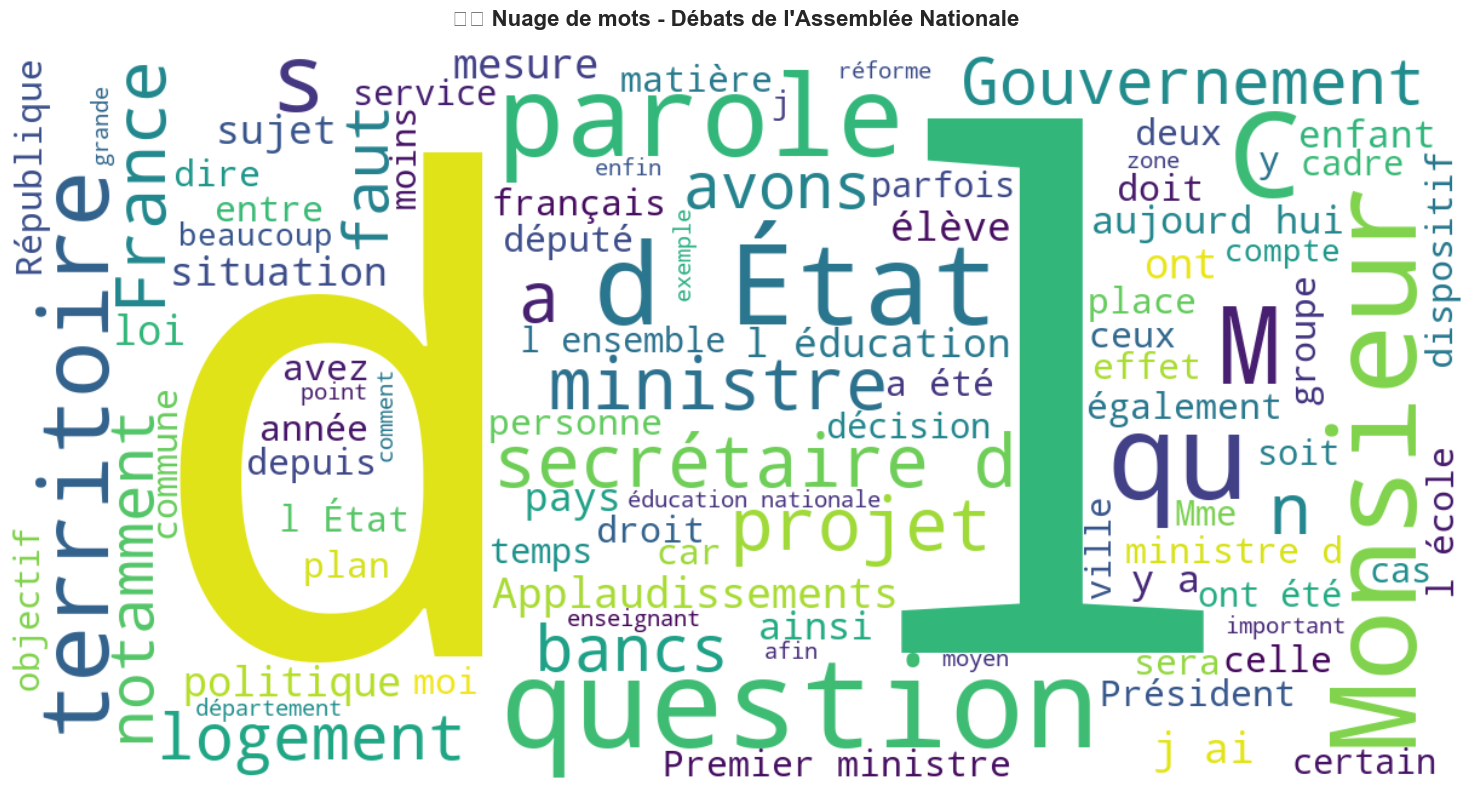

In [30]:
print("☁️ Génération du nuage de mots (peut prendre quelques secondes)...")

# Combiner tous les textes
all_text = ' '.join(df['texte'].dropna().head(1000))  # Limiter à 1000 premiers docs pour la rapidité

# Mots vides français
stopwords_fr = set([
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'et', 'en', 'à', 'au', 'aux',
    'pour', 'par', 'sur', 'dans', 'avec', 'sans', 'est', 'sont', 'être', 'avoir',
    'ce', 'cette', 'ces', 'qui', 'que', 'dont', 'où', 'il', 'elle', 'on', 'nous',
    'vous', 'ils', 'elles', 'se', 'sa', 'son', 'ses', 'leur', 'leurs', 'je', 'tu',
    'me', 'te', 'nous', 'vous', 'mon', 'ma', 'mes', 'ton', 'ta', 'tes', 'notre',
    'votre', 'nos', 'vos', 'ne', 'pas', 'plus', 'tout', 'tous', 'toute', 'toutes',
    'peut', 'fait', 'faire', 'très', 'bien', 'donc', 'aussi', 'mais', 'ou', 'si',
    'comme', 'alors', 'ici', 'là', 'encore', 'même', 'autre', 'autres', 'cela', 'ceci'
])

# Créer le nuage de mots
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords=stopwords_fr,
    colormap='viridis',
    max_words=100
).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Nuage de mots - Débats de l\'Assemblée Nationale', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


9️⃣ Recherche d'exemples sur le thème de l'insécurité

In [31]:
def search_theme(query_text, size=10):
    """
    Recherche des interventions contenant un terme spécifique
    """
    search_body = {
        "query": {
            "match": {
                "texte": {
                    "query": query_text,
                    "operator": "or"
                }
            }
        },
        "size": size,
        "sort": [{"date_seance": {"order": "desc"}}],
        "_source": ["date_seance", "orateur_nom", "section_titre", "texte", "legislature"]
    }
    
    response = es.search(index=index_name, body=search_body)
    return response['hits']['hits']

# %% Recherche sur le thème de l'insécurité
themes_insecurite = ["insécurité", "sécurité", "délinquance", "criminalité", "violence"]

print("🔍 Recherche d'interventions sur le thème de l'insécurité:\n")
print("="*80)

for theme in themes_insecurite:
    results = search_theme(theme, size=3)
    print(f"\n🔎 Mot-clé: '{theme}' → {len(results)} résultats (affichage des 3 premiers)")
    
    for i, hit in enumerate(results, 1):
        doc = hit['_source']
        print(f"\n   [{i}] {doc['date_seance']} - {doc['orateur_nom']}")
        print(f"       Section: {doc.get('section_titre', 'N/A')[:70]}...")
        
        # Extraire un extrait contenant le mot-clé
        texte = doc['texte']
        idx = texte.lower().find(theme.lower())
        if idx != -1:
            start = max(0, idx - 50)
            end = min(len(texte), idx + 100)
            extrait = "..." + texte[start:end] + "..."
            print(f"       Extrait: {extrait}")


🔍 Recherche d'interventions sur le thème de l'insécurité:


🔎 Mot-clé: 'insécurité' → 3 résultats (affichage des 3 premiers)

   [1] 2020-12-07 - Mme Béatrice Descamps.
       Section: Code mondial antidopage et lutte contre le dopage...
       Extrait: ...une réponse à cette situation qui crée une grande insécurité juridique. Les avancées de ce texte sont nombreuses: les sanctions proportionnées selon ...

   [2] 2020-11-23 - Mme Valérie Six.
       Section: Projet de loi de financement de la sécurité sociale pour 2021...
       Extrait: ... se sont affranchis de cette doctrine, créant une insécurité juridique pour le personnel et pour beaucoup de collectivités. L’an dernier, le même déba...

   [3] 2020-11-20 - M. Alexis Corbière.
       Section: Sécurité globale...
       Extrait: ...à est le paradoxe de cet article, qui produit une insécurité globale vis-à-vis de la police. Parce que s’il n’y a plus d’images, que reste-t-il? La v...

🔎 Mot-clé: 'sécurité' → 3 résultats (affichage

C:\Users\simon\AppData\Local\Temp\ipykernel_7192\3416162117.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=search_body)



🔎 Mot-clé: 'délinquance' → 3 résultats (affichage des 3 premiers)

   [1] 2020-12-16 - M. Éric Dupond-Moretti,
       Section: Parquet européen et justice pénale spécialisée...
       Extrait: ...errorisme, contre le crime organisée et contre la délinquance économique et financière. Je remercie l’Assemblée nationale d’avoir enrichi ces disposit...

   [2] 2020-12-16 - M. Pascal Brindeau.
       Section: Parquet européen et justice pénale spécialisée...
       Extrait: ...s qu’elles n’ont jamais arrêté les malfrats et la délinquance. C’est pourquoi nous appelons le Gouvernement et le Président de la République à faire œ...

   [3] 2020-12-16 - M. Jean-Félix Acquaviva.
       Section: Parquet européen et justice pénale spécialisée...
       Extrait: ...erses dispositions liées à la criminalité et à la délinquance financière. En effet, la mesure permettant à l’État de confier à des associations d’inté...

🔎 Mot-clé: 'criminalité' → 3 résultats (affichage des 3 premiers)

   [1] 2020-12-1